### Installing Dependencies

In [158]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

### Preprocessing and Cleaning Data

In [176]:
df = pd.read_csv("dogdata.csv")
# Cleaning:
# Remove rows with NaN values 
df = df.dropna()
# Remove rows that have 'of' as their popularity value
mask = df['popularity'] != 'of'
df = df[mask]
# Preprocessing:
# Calculate average height
df['avg_height'] = (df['min_height'] + df['max_height']) / 2
# Calculate average weight
df['avg_weight'] = (df['min_weight'] + df['max_weight']) / 2
# Calculate max value of max_height
max_height = df['max_height'].max()
# Calculate max value of max_weight
max_weight = df['max_weight'].max()
# Make sure popularity data is in float form
df['popularity'] = df['popularity'].astype(float)
# Calculate max value of popularity
max_pop = df['popularity'].max()
# Apply Max Scaling
df['scaled_avg_height'] = df['avg_height'] / max_height
df['scaled_avg_weight'] = df['avg_weight'] / max_weight
df['scaled_pop'] = df['popularity'] / max_pop
# Put Scaled and Relevant data into new dataframe
breed_data = df[['scaled_pop','scaled_avg_height','scaled_avg_weight','grooming_frequency_value','shedding_value','energy_level_value','trainability_value','demeanor_value']]
breed_data = pd.concat([df.iloc[:,0], breed_data], axis=1)
breed_data.columns.values[0] = 'Breeds'
# Save the DataFrame to a new CSV file
breed_data.to_csv('breed_data.csv', index=False)
print("Cleaned data saved to 'breed_data.csv'")

# # Repeat this process for the cluster (breed groups) data
# df2 = pd.read_csv('merged_data_latest.csv')
# # Store the list of breeds in each group in a dictionary so that we can output them to the user
# breed_clusters = df2.groupby('Cluster')['Breed'].apply(list).to_dict()
# # Preprocessing:
# df2 = df2.drop(columns=['Breed', 'popularity'])
# df2 = df2.apply(pd.to_numeric, errors='coerce').dropna()
# df2 = df2.groupby('Cluster').mean()
# df2.head()
# # Calculate average height
# df2['avg_height'] = (df2['min_height'] + df2['max_height']) / 2
# # Calculate average weight
# df2['avg_weight'] = (df2['min_weight'] + df2['max_weight']) / 2
# # Apply Max Scaling
# df2['scaled_avg_height'] = df2['avg_height'] / max_height
# df2['scaled_avg_weight'] = df2['avg_weight'] / max_weight
# cluster_data = df2[['scaled_avg_height','scaled_avg_weight','grooming_frequency_value','shedding_value','energy_level_value','trainability_value','demeanor_value']]
# # Save the DataFrame to a new CSV file
# cluster_data.to_csv('cluster_data.csv', index=False)
# print("Cleaned data saved to 'cluster_data.csv'")

# Repeat this process for the final/new cluster (breed groups) data
df1 = pd.read_csv('clusters_output.csv')
df_filtered = df1[df1['Breed'].isin(breed_data['Breeds'])]
df2 = breed_data.copy()
df2['Cluster'] = df_filtered['Cluster_KMeans_Word2Vec_TFIDF']
df2 = df2.drop(columns=['Breeds', 'scaled_pop'])
# Store the list of breeds in each group in a dictionary so that we can output them to the user
breed_clusters = df_filtered.groupby('Cluster_KMeans_Word2Vec_TFIDF')['Breed'].apply(list).to_dict()
# Preprocessing:
df2 = df2.groupby('Cluster').mean()
cluster_data = df2[['scaled_avg_height','scaled_avg_weight','grooming_frequency_value','shedding_value','energy_level_value','trainability_value','demeanor_value']]
# Save the DataFrame to a new CSV file
cluster_data.to_csv('cluster_data.csv', index=False)
print("Cleaned data saved to 'cluster_data.csv'")

Cleaned data saved to 'breed_data.csv'
Cleaned data saved to 'cluster_data.csv'


### Defining function for determining optimal breed combination
1. This first function includes a penalty hyperparameter in the loss function. This hyperparameter would need to be tuned by using some real mixed breed data in order to justify the choice of value for it.

In [113]:
def estimate_dog_breed(breed_data, y):
    # Prepare data for use in loss function
    data = breed_data.drop(columns=['Breeds', 'scaled_pop'])
    B = np.asarray(data).T
    # Extract popularity data to penalise rare breeds in loss function. The hope is that this will give more realistic mixtures.
    pop = breed_data['scaled_pop']
    # pop_penalty = 0.05
    # Defining the loss function (SSE) to minimise
    def lossSSE(w):
        x = B @ w
        diffsqrd = (x - y) ** 2
        SSE = diffsqrd.sum() # + pop_penalty*(w @ pop) # SSE with pop penalty
        return SSE

    # Defining constraint: Elements of w must sum to 1
    constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Initial guess of weights (Random values between 0 and 1)
    w0 = np.random.uniform(0, 1, size=B.shape[1])
    # Normalise initial guess to meet constraint
    w0 /= np.sum(w0)

    # Define bounds [0,1] for all weights
    bounds = [(0, 1) for _ in range(B.shape[1])]

    # Minimize using SLSQP (supports constraints)
    result = minimize(lossSSE, w0, method='SLSQP', bounds=bounds, constraints=[constraint])
    w_adjusted = result.x
    
    # Find indices of top 4 values
    top_indices = np.argsort(w_adjusted)[-4:]
    
    # Create a mask to zero out other values
    mask = np.zeros_like(w_adjusted, dtype=bool)
    mask[top_indices] = True
    
    # Update array with the mask
    w_adjusted[~mask] = 0
    
    # Renormalize to sum to 1
    if np.sum(w_adjusted) > 0:
        w_adjusted /= np.sum(w_adjusted)  # Normalize to sum to 1
    # Discard weights less than 0.1
    w_adjusted = np.where(result.x < 0.1, 0, result.x)
    # Renormalize to sum to 1
    if np.sum(w_adjusted) > 0:
        w_adjusted /= np.sum(w_adjusted)  # Normalize to sum to 1
        
    return w_adjusted

# Defining some functions that allow us to analyse and display results:

def get_breed0(w_adjusted):
    breed_indices = [i for i in range(len(w_adjusted)) if w_adjusted[i] != 0]
    if len(breed_indices) == 1:
        return breed_indices[0]
    else:
        return None

def get_breeds(w_adjusted):
    breed_indices = [i for i in range(len(w_adjusted)) if w_adjusted[i] != 0]
    if breed_indices:
        return breed_indices
    else:
        return None
    
def print_breed_guess(w_adjusted):
    # Print results
    percents = [round(i*100, 0) for i in w_adjusted if i != 0]
    breeds = [breed_data.iloc[i, 0] for i in range(len(w_adjusted)) if w_adjusted[i] != 0]
    if not breeds:
        print("We were unable to determine a breed mixture for your dog")
    else:
        print('We estimate your dog to be:')
        for i in range(len(breeds)):
            print(percents[i], '% ', breeds[i])

2. Here we will redefine estimate_dog_breed() with MSE as the loss function instead of SSE. Why? Because MSE is generally favoured to SSE. We will compare the performance of the two functions later and select the best performing one.

In [ ]:
def estimate_dog_breedMSE(breed_data, y):
    # Prepare data for use in loss function
    data = breed_data.drop(columns=['Breeds', 'scaled_pop'])
    B = np.asarray(data).T
    # Defining the loss function (MSE) to minimise
    def lossMSE(w):
        x = B @ w
        diffsqrd = (x - y) ** 2
        MSE = diffsqrd.mean()
        return MSE

    # Defining constraint: Elements of w must sum to 1
    constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Initial guess of weights (Random values between 0 and 1)
    w0 = np.random.uniform(0, 1, size=B.shape[1])
    # Normalise initial guess to meet constraint
    w0 /= np.sum(w0)

    # Define bounds [0,1] for all weights
    bounds = [(0, 1) for _ in range(B.shape[1])]

    # Minimize using SLSQP (supports constraints)
    result = minimize(lossMSE, w0, method='SLSQP', bounds=bounds, constraints=[constraint])
    w_adjusted = result.x
    
    # Find indices of top 4 values
    top_indices = np.argsort(w_adjusted)[-4:]
    
    # Create a mask to zero out other values
    mask = np.zeros_like(w_adjusted, dtype=bool)
    mask[top_indices] = True
    
    # Update array with the mask
    w_adjusted[~mask] = 0
    
    # Renormalize to sum to 1
    if np.sum(w_adjusted) > 0:
        w_adjusted /= np.sum(w_adjusted)  # Normalize to sum to 1
    # Discard weights less than 0.1
    w_adjusted = np.where(result.x < 0.1, 0, result.x)
    # Renormalize to sum to 1
    if np.sum(w_adjusted) > 0:
        w_adjusted /= np.sum(w_adjusted)  # Normalize to sum to 1
    return w_adjusted

In [170]:
def estimate_dog_breedcos(breed_data, y):
    # Prepare data for use in loss function
    data = breed_data.drop(columns=['Breeds', 'scaled_pop'])
    B = np.asarray(data).T
    # Define Loss Function (Cosine Similarity instead of SSE)
    def lossCosine(w):
        x = B @ w
        x = x.reshape(1, -1)  # Ensure correct shape
        y_reshaped = np.asarray(y).reshape(1, -1)
        similarity = cosine_similarity(x, y_reshaped)[0, 0]
        return 1 - similarity  # Minimize dissimilarity

    # Defining constraint: Elements of w must sum to 1
    constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Initial guess of weights (Random values between 0 and 1)
    w0 = np.random.uniform(0, 1, size=B.shape[1])
    # Normalise initial guess to meet constraint
    w0 /= np.sum(w0)

    # Define bounds [0,1] for all weights
    bounds = [(0, 1) for _ in range(B.shape[1])]

    # Minimize using SLSQP (supports constraints)
    result = minimize(lossCosine, w0, method='SLSQP', bounds=bounds, constraints=[constraint])
    w_adjusted = result.x
    
    # Find indices of top 4 values
    top_indices = np.argsort(w_adjusted)[-4:]
    
    # Create a mask to zero out other values
    mask = np.zeros_like(w_adjusted, dtype=bool)
    mask[top_indices] = True
    
    # Update array with the mask
    w_adjusted[~mask] = 0
    
    # Renormalize to sum to 1
    if np.sum(w_adjusted) > 0:
        w_adjusted /= np.sum(w_adjusted)  # Normalize to sum to 1
    # Discard weights less than 0.1
    w_adjusted = np.where(result.x < 0.1, 0, result.x)
    # Renormalize to sum to 1
    if np.sum(w_adjusted) > 0:
        w_adjusted /= np.sum(w_adjusted)  # Normalize to sum to 1
    return w_adjusted

4. Here, instead of using a penalty hyperparameter to deal with the issue of returning highly improbable breed combinations, we will simply only use the 50 most popular breeds in our dataset. This is simply a suggestioin of how we could deal with the issue of popularity.

In [162]:
def estimate_dog_breed_pop(breed_data, y):
    # Extract only the 50 most popular dog breeds
    scaled_val = 50 / max_pop
    most_pop = breed_data['scaled_pop'] <= scaled_val
    pop_breed_data = breed_data[most_pop]
    pop_data = pop_breed_data.drop(columns=['Breeds', 'scaled_pop'])
    Bpop = np.asarray(pop_data).T
    # Defining the loss function (SSE) to minimise
    def loss(w):
        x = Bpop @ w
        diffsqrd = (x - y) ** 2
        return diffsqrd.sum() # SSE

    # Defining constraint: Elements of w must sum to 1
    constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Initial guess of weights (Random values between 0 and 1)
    w0 = np.random.uniform(0, 1, size=Bpop.shape[1])
    # Normalise initial guess to meet constraint
    w0 /= np.sum(w0)

    # Define bounds [0,1] for all weights
    bounds = [(0, 1) for _ in range(Bpop.shape[1])]

    # Minimize using SLSQP (supports constraints)
    result = minimize(loss, w0, method='SLSQP', bounds=bounds, constraints=[constraint])

    # Discard weights of less than 0.25
    w_adjusted = np.where(result.x < 0.25, 0, result.x)

    # Renormalize to sum to 1
    if np.sum(w_adjusted) > 0:
        w_adjusted /= np.sum(w_adjusted)  # Normalize to sum to 1
    # Print results
    percents = [round(i*100, 0) for i in w_adjusted if i != 0]
    breeds = [pop_breed_data.iloc[i, 0] for i in range(len(w_adjusted)) if w_adjusted[i] != 0]
    print('We estimate your dog to be:')
    for i in range(len(breeds)):
        print(percents[i], '% ', breeds[i])

To offer the user with some more general information we will, aswell as proposing a breed mixture, return a group/s of dogs that their dog is most similar to. This will be done by finding the nearest cluster centroid (of the AKC feature data) to the input dog.

In [163]:
# Use Nearest Neighour from scikit learn to allow te nearest cluster centroid of any datapoint (i.e. input dog feature vector) to be found
C = np.asarray(cluster_data)
classes = list(breed_clusters.keys())
print(classes)
nn = NearestNeighbors(n_neighbors=3)
nn.fit(C)

def estimate_dog_cluster(classes, y):
    point = np.asarray([np.asarray(y)])
    # Find the nearest neighbor
    distance, indices = nn.kneighbors(point)
    nearest_class = [classes[i] for i in indices[0]]
    for i in range(len(nearest_class)):
        if i == 0:
            print("You're dog fits best in this dog group:", nearest_class[i])
            print('The dogs of this group are:', breed_clusters.get(nearest_class[i]))
        else:
            print("You're dog may also fit in this dog group:", nearest_class[i])
            print('The dogs of this group are:', breed_clusters.get(nearest_class[i]))

[0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41, 43, 44, 45, 46, 47, 50, 51, 52, 53, 55, 56, 57, 60, 61, 62, 63, 64, 65, 67, 70, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 90]


### Tests

In [172]:
data = breed_data.drop(columns=['Breeds', 'scaled_pop'])
assert get_breed0(estimate_dog_breed(breed_data, data.iloc[0])) == 0, "Should be classed as breed 0, i.e Affenpinscher"
print_breed_guess(estimate_dog_breed(breed_data, data.iloc[0]))
estimate_dog_cluster(classes, data.iloc[0])

We estimate your dog to be:
100.0 %  Affenpinscher
You're dog fits best in this dog group: 86
The dogs of this group are: ['Coton de Tulear', 'Pomeranian', 'Pug']
You're dog may also fit in this dog group: 81
The dogs of this group are: ['French Bulldog', 'Havanese', 'Shih Tzu']
You're dog may also fit in this dog group: 52
The dogs of this group are: ['Beagle', 'Cocker Spaniel', 'English Springer Spaniel']


### Accuracy
i.e. the precentage of Pure Breeds that the program guesses exactly right e.g. Affenpinscher should yield 100% Affenpinscher otherwise it is deemed wrong.

In [ ]:
# Calculating Accuracy for SSE function
count = 0
for i in range(len(data)-1):
    if i == get_breed0(estimate_dog_breed(breed_data, data.iloc[i])):
        count += 1
    if i%5==0:
        print("Breed", i, "complete.")
accuracy_SSE = count*100/len(data)
print("Accuracy using SSE loss on Pure Breed Data = ", accuracy_SSE, "%")
# SSE Accuracy ~ 60 %

In [ ]:
# Calculating Accuracy for MSE function
count = 0
for i in range(len(data)-1):
    if i == get_breed0(estimate_dog_breedMSE(breed_data, data.iloc[i])):
        count += 1
    if i%5==0:
        print("Breed", i, "complete.")
accuracy_MSE = count*100/len(data)
print("Accuracy using MSE loss on Pure Breed Data = ", accuracy_MSE, "%")
# MSE Accuracy ~ 46 %

In [ ]:
# Calculating Accuracy for cosine dissimiliarity function
count = 0
for i in range(len(data)-1):
    if i == get_breed0(estimate_dog_breedcos(breed_data, data.iloc[i])):
        count += 1
    if i%5==0:
        print("Breed", i, "complete.")
accuracy_cos = count*100/len(data)
print("Accuracy using cosine dissimilarity on Pure Breed Data = ", accuracy_cos, "%")
# Cosine Dissimilarity Accuracy ~ 30 %

Interestingly, a SSE loss function outperforms a MSE loss function on a metric of classification accuracy for pure breeds. So we have decided to use SSE as the loss function.

### How about 'Partial Accuracy'?
i.e how often is the correct dog among the dogs in the breed mixture that is guessed?

In [ ]:
# Calculating Partial Accuracy for SSE function
count = 0
for i in range(len(data)-1):
    breed_mix = get_breeds(estimate_dog_breed(breed_data, data.iloc[i]))
    for j in breed_mix:
        if i == j:
            count += 1
    if i%5==0:
        print("Breed", i, "complete.")
paccuracy_SSE = count*100/len(data)
print("Partial accuracy using SSE loss on Pure Breed Data = ", paccuracy_SSE, "%")
# SSE Partial Accuracy ~  80%

In [ ]:
# Calculating Partial Accuracy for MSE function
count = 0
for i in range(len(data)-1):
    breed_mix = get_breeds(estimate_dog_breedMSE(breed_data, data.iloc[i]))
    for j in breed_mix:
        if i == j:
            count += 1
    if i%5==0:
        print("Breed", i, "complete.")
paccuracy_MSE = count*100/len(data)
print("Partial accuracy using MSE loss on Pure Breed Data = ", paccuracy_MSE, "%")
# MSE Partial Accuracy ~  81%

In [ ]:
# Calculating Accuracy for cosine dissimiliarity function
count = 0
for i in range(len(data)-1):
    breed_mix = get_breeds(estimate_dog_breedcos(breed_data, data.iloc[i]))
    for j in breed_mix:
        if i == j:
            count += 1
    if i%5==0:
        print("Breed", i, "complete.")
paccuracy_cos = count*100/len(data)
print("Partial accuracy using cosine dissimilarity on Pure Breed Data = ", paccuracy_cos, "%")
# Cosine Dissimilarity Partial Accuracy ~ 67 %

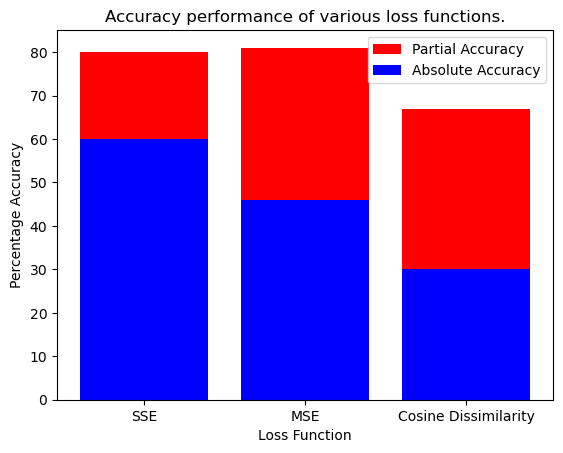

In [180]:
# Accuracy Data for the bar chart
loss_funs = ['SSE', 'MSE', 'Cosine Dissimilarity']
accs = [60, 46, 30]
paccs = [80, 81, 67]
plt.bar(loss_funs, paccs, color='red', label='Partial Accuracy')
plt.bar(loss_funs, accs, color='blue', label='Absolute Accuracy')
plt.xlabel('Loss Function')
plt.ylabel('Percentage Accuracy')
plt.title('Accuracy performance of various loss functions.')
plt.legend()
plt.show()

### Taking User inputs

In [118]:
age = int(input('How old is your dog in earth years?'))
if age <= 3:
    print("Please understand that your dog is still young and may not have yet developed all of the attributes of it's breed or breed mixture. This makes it far more difficult to guess it's breed / breed mixture.")

How old is your dog in earth years? 10


In [119]:
height = int(input('What height is your dog (cm)?'))
scaled_height = height / max_height

What height is your dog (cm)? 30


In [120]:
weight = int(input('What weight is your dog (kg)?'))
scaled_weight = weight / max_weight

What weight is your dog (kg)? 10


In [122]:
groomingvals = [i for i in df['grooming_frequency_value'].dropna().unique()]
groomingfreqs = [i for i in df['grooming_frequency_category'].dropna().unique()]
for i in groomingfreqs:
    print(groomingfreqs.index(i), i)
groomingval = groomingvals[int(input('From the above unordered list, enter the number that corresponds to the option that best describes your dogs grooming demands.'))]

0 2-3 Times a Week Brushing
1 Daily Brushing
2 Occasional Bath/Brush
3 Weekly Brushing
4 Specialty/Professional


From the above unordered list, enter the number that corresponds to the option that best describes your dogs grooming demands. 2


In [123]:
sheddingvals = [i for i in df['shedding_value'].dropna().unique()]
sheddingfreqs = [i for i in df['shedding_category'].dropna().unique()]
for i in sheddingfreqs:
    print(sheddingfreqs.index(i), i)
sheddingval = sheddingvals[int(input("From the above unordered list, enter the number that corresponds to the option that best describes how frequently your dog sheds it's fur."))]

0 Seasonal
1 Infrequent
2 Occasional
3 Regularly
4 Frequent


From the above unordered list, enter the number that corresponds to the option that best describes how frequently your dog sheds it's fur. 0


In [124]:
energyvals = [i for i in df['energy_level_value'].dropna().unique()]
energycategs = [i for i in df['energy_level_category'].dropna().unique()]
for i in energycategs:
    print(energycategs.index(i), i)
energyval = energyvals[int(input("From the above unordered list, enter the number that corresponds to the option that best describes your dog's energy level."))]

0 Regular Exercise
1 Energetic
2 Needs Lots of Activity
3 Couch Potato
4 Calm


From the above unordered list, enter the number that corresponds to the option that best describes your dog's energy level. 4


In [125]:
trainabilityvals = [i for i in df['trainability_value'].dropna().unique()]
trainabilitycategs = [i for i in df['trainability_category'].dropna().unique()]
for i in trainabilitycategs:
    print(trainabilitycategs.index(i), i)
trainabilityval = trainabilityvals[int(input("From the above unordered list, enter the number that corresponds to the option that best describes how easy your dog is to train."))]

0 Easy Training
1 May be Stubborn
2 Eager to Please
3 Independent
4 Agreeable


From the above unordered list, enter the number that corresponds to the option that best describes how easy your dog is to train. 4


In [126]:
demeanorvals = [i for i in df['demeanor_value'].dropna().unique()]
demeanorcategs = [i for i in df['demeanor_category'].dropna().unique()]
for i in demeanorcategs:
    print(demeanorcategs.index(i), i)
demeanorval = demeanorvals[int(input("From the above unordered list, enter the number that corresponds to the option that best describes the demeanor of your dog."))]

0 Outgoing
1 Aloof/Wary
2 Friendly
3 Alert/Responsive
4 Reserved with Strangers


From the above unordered list, enter the number that corresponds to the option that best describes the demeanor of your dog. 0


In [ ]:
y = [scaled_height,scaled_weight,groomingval,sheddingval,energyval,trainabilityval,demeanorval]
estimate_dog_breed(breed_data, y)
estimate_dog_cluster(classes, y)